In [1]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml
import pickle

In [2]:
pristine = pd.read_parquet('/arc/projects/k-pop/pristine/Pristine_CFIS.parquet',
                           columns=["CaHK_0","pmra_1","pmdec_1","pmra_error_1","pmdec_error_1","g_chp_psf","r_chp_psf","i_chp_psf","z_chp_psf","y_chp_psf","MAG_AUTO",
                                    "phot_g_mean_mag_1","phot_bp_mean_mag_1","phot_rp_mean_mag_1"])

In [3]:
pristine = pristine.loc[(pristine["g_chp_psf"] < 1e19) & (pristine["r_chp_psf"] < 1e19) & (pristine["i_chp_psf"] < 1e19) & \
                        (pristine["z_chp_psf"] < 1e19) & (pristine["y_chp_psf"] < 1e19) & (pristine["MAG_AUTO"] < 95) & \
                        (np.isnan(pristine["phot_g_mean_mag_1"]) == False) & (np.isnan(pristine["phot_bp_mean_mag_1"]) == False) & \
                        (np.isnan(pristine["pmra_1"]) == False) & (np.isnan(pristine["pmdec_1"]) == False) & \
                        (np.isnan(pristine["pmra_error_1"]) == False) & (np.isnan(pristine["pmdec_error_1"]) == False) & \
                        (np.isnan(pristine["phot_rp_mean_mag_1"]) == False)]

In [4]:
df = vaex.from_pandas(pd.DataFrame({'PMRA': pristine['pmra_1'],
                   'PMDec': pristine['pmdec_1'],
                   'PMRAerr': pristine['pmra_error_1'],
                   'PMDecerr': pristine['pmdec_error_1'],
                   'G_gaia': pristine['CaHK_0']-pristine['phot_g_mean_mag_1'],
                   'B_gaia': pristine['CaHK_0']-pristine['phot_bp_mean_mag_1'],
                   'R_gaia': pristine['CaHK_0']-pristine['phot_rp_mean_mag_1'],
                   'G_pan': pristine['CaHK_0']-pristine['g_chp_psf'],
                   'R_pan': pristine['CaHK_0']-pristine['r_chp_psf'],
                   'I_pan': pristine['CaHK_0']-pristine['i_chp_psf'],
                   'Z_pan': pristine['CaHK_0']-pristine['z_chp_psf'],
                   'Y_pan': pristine['CaHK_0']-pristine['y_chp_psf'],
                   'AUTO_cfis': pristine['CaHK_0']-pristine['MAG_AUTO']}))

# df2 = vaex.from_pandas(pd.DataFrame({'Fe/H': pristine['FEH_ADOP']}, index = np.arange(0,len(pristine))))

In [5]:
print(df.shape)
data = df.dropna()
print(data.shape)

(3718245, 13)
(3718245, 13)


In [6]:
reducer = umap.UMAP(random_state=69,verbose=True)

In [7]:
scaled_star_data = StandardScaler().fit_transform(data)

In [8]:
reducer.fit(scaled_star_data)

UMAP(random_state=69, verbose=True)
Mon Feb 28 02:10:41 2022 Construct fuzzy simplicial set
Mon Feb 28 02:10:41 2022 Finding Nearest Neighbors
Mon Feb 28 02:10:41 2022 Building RP forest with 64 trees
Mon Feb 28 02:11:23 2022 NN descent for 22 iterations
	 1  /  22
	 2  /  22
	Stopping threshold met -- exiting after 2 iterations
Mon Feb 28 02:15:34 2022 Finished Nearest Neighbor Search
Mon Feb 28 02:16:07 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Mon Feb 28 03:18:03 2022 Finished embedding


UMAP(random_state=69, verbose=True)

In [9]:
# sspp = pd.read_csv('/arc/home/aydanmckay/leftjoinpristinesspp.csv',
#                    usecols=["CaHK_0_p","pmra_1_p","pmdec_1_p","g_chp_psf_p","r_chp_psf_p","i_chp_psf_p","z_chp_psf_p","y_chp_psf_p","MAG_AUTO_p",
#                             "phot_g_mean_mag_1_p","phot_bp_mean_mag_1_p","phot_rp_mean_mag_1_p","AFE_s","FEH_ADOP_s","TEFF_ADOP_s","LOGG_ADOP_s"])
# sspp = sspp.loc[(sspp["g_chp_psf_p"] < 1e19) & (sspp["r_chp_psf_p"] < 1e19) & (sspp["i_chp_psf_p"] < 1e19) & \
#                         (sspp["z_chp_psf_p"] < 1e19) & (sspp["y_chp_psf_p"] < 1e19) & (sspp["MAG_AUTO_p"] < 95) & \
#                         (np.isnan(sspp["phot_g_mean_mag_1_p"]) == False) & (np.isnan(sspp["phot_bp_mean_mag_1_p"]) == False) & \
#                         (np.isnan(sspp["pmra_1_p"]) == False) & (np.isnan(sspp["pmdec_1_p"]) == False) & \
#                         (np.isnan(sspp["phot_rp_mean_mag_1_p"]) == False)]
# sspp = sspp.replace({'AFE_s': np.nan}, -90)
# sspp = sspp.replace({'FEH_ADOP_s': np.nan}, -90)
# df_joined_fe = vaex.from_pandas(pd.DataFrame({'PMRA': sspp['pmra_1_p'],
#                       'PMDec': sspp['pmdec_1_p'],
#                       'G_gaia': sspp["CaHK_0_p"]-sspp['phot_g_mean_mag_1_p'],
#                       'B_gaia': sspp["CaHK_0_p"]-sspp['phot_bp_mean_mag_1_p'],
#                       'R_gaia': sspp["CaHK_0_p"]-sspp['phot_rp_mean_mag_1_p'],
#                       'G_pan': sspp["CaHK_0_p"]-sspp['g_chp_psf_p'],
#                       'R_pan': sspp["CaHK_0_p"]-sspp['r_chp_psf_p'],
#                       'I_pan': sspp["CaHK_0_p"]-sspp['i_chp_psf_p'],
#                       'Z_pan': sspp["CaHK_0_p"]-sspp['z_chp_psf_p'],
#                       'Y_pan': sspp["CaHK_0_p"]-sspp['y_chp_psf_p'],
#                       'AUTO_cfis': sspp["CaHK_0_p"]-sspp['MAG_AUTO_p']},
#                       index=np.arange(0,len(sspp))))
# df2_afe = pd.DataFrame({'a/Fe': sspp['AFE_s']}, index = np.arange(0,len(sspp)))
# df2_feh = pd.DataFrame({'Fe/H': sspp['FEH_ADOP_s']}, index = np.arange(0,len(sspp)))
# df2_logg = pd.DataFrame({'logg': sspp['LOGG_ADOP_s']}, index = np.arange(0,len(sspp)))
# df2_teff = pd.DataFrame({'Teff': sspp['TEFF_ADOP_s']}, index = np.arange(0,len(sspp)))
# print(df_joined_fe.shape)
# df_joined_fe = df_joined_fe.dropna()
# print(df_joined_fe.shape)
# print(df2_afe.shape)
# df2_afe = df2_afe.dropna()
# print(df2_afe.shape)
# print(df2_feh.shape)
# df2_feh = df2_feh.dropna()
# print(df2_feh.shape)
# print(df2_logg.shape)
# df2_logg = df2_logg.dropna()
# print(df2_logg.shape)
# print(df2_teff.shape)
# df2_teff = df2_teff.dropna()
# print(df2_teff.shape)

In [10]:
# %%time
# scaled_star_data_joined_fe = StandardScaler().fit_transform(df_joined_fe)
# embedding_joined_fe = reducer.transform(scaled_star_data_joined_fe)

In [11]:
# mask_feh = df2_feh['Fe/H'] > -9
# plt.figure(figsize=(12,12))
# plt.scatter(embedding[:, 0], embedding[:, 1], c='k', alpha=0.1, s=5)
# plt.scatter(embedding_joined_fe[:, 0][mask_feh], embedding_joined_fe[:, 1][mask_feh],c=df2_feh['Fe/H'][mask_feh], cmap='Spectral', s=5)
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar()
# plt.title("SDSS DR17 Catalogue Left Joined onto Pristine Dataset, Coloured by SEGUE Fe/H")
# plt.savefig('/arc/home/aydanmckay/pmssppmappedtopristinecoloursoverplot.png')

In [12]:
# sm_ll_feh = []
# sm_ll_logg = []
# sm_ll_teff = []
# for x,y,feh,logg,teff in zip(embedding_joined_fe[:, 0][mask_feh],embedding_joined_fe[:, 1][mask_feh],
#                              df2_feh['Fe/H'][mask_feh],df2_logg['logg'][mask_feh],df2_teff['Teff'][mask_feh]):
#     if x < -1 and y < -1:
#         sm_ll_feh.append(feh)
#         sm_ll_logg.append(logg)
#         sm_ll_teff.append(teff)

In [13]:
# plt.scatter(sm_ll_teff,sm_ll_logg)
# plt.title('Effective Temperature vs. logg on the Small Low Metallicity Blob')
# plt.xlabel('Effective temperature')
# plt.ylabel('logg')
# plt.grid()
# plt.savefig('/arc/home/aydanmckay/teffloggblob.png')

In [14]:
# plt.scatter(sm_ll_logg,sm_ll_feh)
# plt.title('logg vs. Metallicity on the Small Low Metallicity Blob')
# plt.ylabel('Metallicity')
# plt.xlabel('logg')
# plt.grid()
# plt.savefig('/arc/home/aydanmckay/loggfehblob.png')

In [15]:
# %%time
# redu = pickle.dumps(reducer)
# filename = 'unsupervisedbetterpickle.obj'

# with open(filename,'wb') as file_object:
#     file_object.write(redu)

# # with open(filename,'rb') as file_object:
# #     raw_data = file_object.read()

# # redu2 = pickle.loads(raw_data)

In [16]:
embedding = reducer.transform(scaled_star_data)

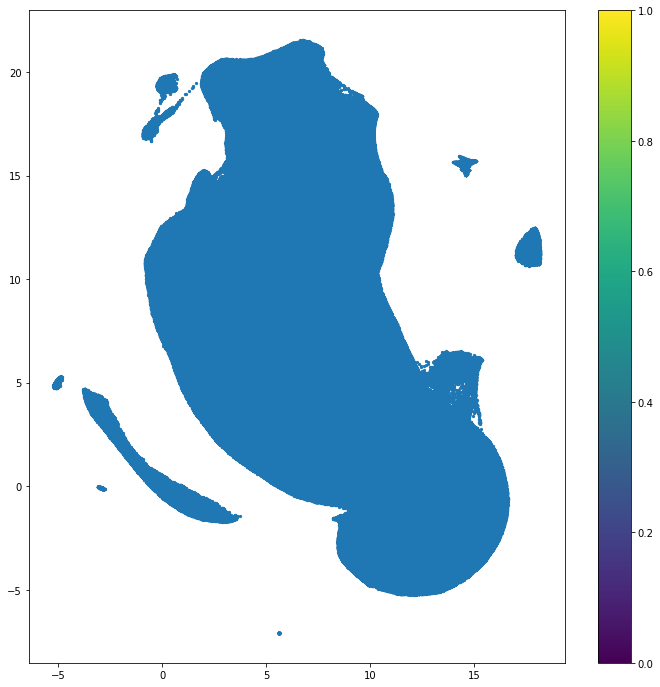

In [17]:
plt.figure(figsize=(12,12))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='hsv', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.savefig('/arc/home/aydanmckay/bigdatapristinecolourshsv.png')

In [18]:
sdss = pd.read_csv('/arc/home/aydanmckay/leftjoinpristinespecobj.csv',
                   usecols=["CaHK_0_p","pmra_1_p","pmdec_1_p","g_chp_psf_p","r_chp_psf_p","i_chp_psf_p","z_chp_psf_p","y_chp_psf_p","MAG_AUTO_p",
                            "phot_g_mean_mag_1_p","phot_bp_mean_mag_1_p","phot_rp_mean_mag_1_p","CLASS_s"])
# sspp = pd.read_csv('/arc/home/aydanmckay/leftjoinpristinesspp.csv',
#                    usecols=["CaHK_0_p","pmra_1_p","pmdec_1_p","g_chp_psf_p","r_chp_psf_p","i_chp_psf_p","z_chp_psf_p","y_chp_psf_p","MAG_AUTO_p",
#                             "phot_g_mean_mag_1_p","phot_bp_mean_mag_1_p","phot_rp_mean_mag_1_p","AFE_s","FEH_ADOP_s"])

In [19]:
sdss.head()

,CaHK_0_p,pmra_1_p,pmdec_1_p,phot_g_mean_mag_1_p,phot_bp_mean_mag_1_p,phot_rp_mean_mag_1_p,g_chp_psf_p,r_chp_psf_p,i_chp_psf_p,z_chp_psf_p,y_chp_psf_p,MAG_AUTO_p,CLASS_s
0,21.972,-0.416,-8.462,13.833454,14.202310,13.300272,14.255604,13.802833,13.653096,13.630348,1.358774e+01,15.705700,NaN
1,25.296,-0.102,-13.107,17.743600,18.087147,17.302958,18.060312,17.742205,17.621430,17.599453,1.757736e+01,18.974701,NaN
2,25.864,-6.181,-2.274,16.413301,17.041140,15.655658,17.248518,16.378054,16.022442,15.873168,1.576375e+01,19.656700,NaN
3,26.582,1.104,-6.515,19.234087,19.529345,18.795353,19.505856,19.224485,19.112057,19.110556,1.906391e+01,20.396700,NaN
4,27.892,NaN,NaN,21.115057,21.349903,20.607525,21.569519,21.110239,20.966051,20.918962,1.000000e+20,20.993000,NaN


In [20]:
sdss.CLASS_s.value_counts()

STAR      79150
QSO       75940
GALAXY    65401
Name: CLASS_s, dtype: int64

In [21]:
sdss = sdss.loc[(sdss["g_chp_psf_p"] < 1e19) & (sdss["r_chp_psf_p"] < 1e19) & (sdss["i_chp_psf_p"] < 1e19) & \
                        (sdss["z_chp_psf_p"] < 1e19) & (sdss["y_chp_psf_p"] < 1e19) & (sdss["MAG_AUTO_p"] < 95) & \
                        (np.isnan(sdss["phot_g_mean_mag_1_p"]) == False) & (np.isnan(sdss["phot_bp_mean_mag_1_p"]) == False) & \
                        (np.isnan(sdss["pmra_1_p"]) == False) & (np.isnan(sdss["pmdec_1_p"]) == False) & \
                        (np.isnan(sdss["phot_rp_mean_mag_1_p"]) == False)]

In [22]:
# sspp = sspp.loc[(sspp["g_chp_psf_p"] < 1e19) & (sspp["r_chp_psf_p"] < 1e19) & (sspp["i_chp_psf_p"] < 1e19) & \
#                         (sspp["z_chp_psf_p"] < 1e19) & (sspp["y_chp_psf_p"] < 1e19) & (sspp["MAG_AUTO_p"] < 95) & \
#                         (np.isnan(sspp["phot_g_mean_mag_1_p"]) == False) & (np.isnan(sspp["phot_bp_mean_mag_1_p"]) == False) & \
#                         (np.isnan(sspp["pmra_1_p"]) == False) & (np.isnan(sspp["pmdec_1_p"]) == False) & \
#                         (np.isnan(sspp["phot_rp_mean_mag_1_p"]) == False)]

In [23]:
sdss = sdss.replace({'CLASS_s': np.nan}, 'Unknown')
sdss.head()

,CaHK_0_p,pmra_1_p,pmdec_1_p,phot_g_mean_mag_1_p,phot_bp_mean_mag_1_p,phot_rp_mean_mag_1_p,g_chp_psf_p,r_chp_psf_p,i_chp_psf_p,z_chp_psf_p,y_chp_psf_p,MAG_AUTO_p,CLASS_s
0,21.972,-0.416,-8.462,13.833454,14.202310,13.300272,14.255604,13.802833,13.653096,13.630348,13.587737,15.705700,Unknown
1,25.296,-0.102,-13.107,17.743600,18.087147,17.302958,18.060312,17.742205,17.621430,17.599453,17.577356,18.974701,Unknown
2,25.864,-6.181,-2.274,16.413301,17.041140,15.655658,17.248518,16.378054,16.022442,15.873168,15.763746,19.656700,Unknown
3,26.582,1.104,-6.515,19.234087,19.529345,18.795353,19.505856,19.224485,19.112057,19.110556,19.063910,20.396700,Unknown
6,21.261,-6.987,-2.044,13.644862,13.927730,13.203995,13.950986,13.646905,13.556214,13.562936,13.553225,14.988400,Unknown


In [24]:
# sspp = sspp.replace({'AFE_s': np.nan}, -90)
# sspp = sspp.replace({'FEH_ADOP_s': np.nan}, -90)
# # sspp.head()

In [25]:
# df_joined = vaex.from_pandas(pd.DataFrame({'PMRA': sdss['pmra_1_p'],
#                    'PMDec': sdss['pmdec_1_p'],
#                    'G_gaia': sdss["CaHK_0_p"]-sdss['phot_g_mean_mag_1_p'],
#                    'B_gaia': sdss["CaHK_0_p"]-sdss['phot_bp_mean_mag_1_p'],
#                    'R_gaia': sdss["CaHK_0_p"]-sdss['phot_rp_mean_mag_1_p'],
#                    'G_pan': sdss["CaHK_0_p"]-sdss['g_chp_psf_p'],
#                    'R_pan': sdss["CaHK_0_p"]-sdss['r_chp_psf_p'],
#                    'I_pan': sdss["CaHK_0_p"]-sdss['i_chp_psf_p'],
#                    'Z_pan': sdss["CaHK_0_p"]-sdss['z_chp_psf_p'],
#                    'Y_pan': sdss["CaHK_0_p"]-sdss['y_chp_psf_p'],
#                    'AUTO_cfis': sdss["CaHK_0_p"]-sdss['MAG_AUTO_p']},
#                    index=np.arange(0,len(sdss))))
# df2 = pd.DataFrame({'Class': sdss['CLASS_s']}, index = np.arange(0,len(sdss)))

In [26]:
df_joined = vaex.from_pandas(pd.DataFrame({'PMRA': sdss['pmra_1_p'],
                   'PMDec': sdss['pmdec_1_p'],
                   'G_gaia': sdss["CaHK_0_p"]-sdss['phot_g_mean_mag_1_p'],
                   'B_gaia': sdss["CaHK_0_p"]-sdss['phot_bp_mean_mag_1_p'],
                   'R_gaia': sdss["CaHK_0_p"]-sdss['phot_rp_mean_mag_1_p'],
                   'G_pan': sdss["CaHK_0_p"]-sdss['g_chp_psf_p'],
                   'R_pan': sdss["CaHK_0_p"]-sdss['r_chp_psf_p'],
                   'I_pan': sdss["CaHK_0_p"]-sdss['i_chp_psf_p'],
                   'Z_pan': sdss["CaHK_0_p"]-sdss['z_chp_psf_p'],
                   'Y_pan': sdss["CaHK_0_p"]-sdss['y_chp_psf_p'],
                   'AUTO_cfis': sdss["CaHK_0_p"]-sdss['MAG_AUTO_p']}))
df2 = pd.DataFrame({'Class': sdss['CLASS_s']})

In [27]:
# df_joined_fe = vaex.from_pandas(pd.DataFrame({'PMRA': sspp['pmra_1_p'],
#                       'PMDec': sspp['pmdec_1_p'],
#                       'G_gaia': sspp["CaHK_0_p"]-sspp['phot_g_mean_mag_1_p'],
#                       'B_gaia': sspp["CaHK_0_p"]-sspp['phot_bp_mean_mag_1_p'],
#                       'R_gaia': sspp["CaHK_0_p"]-sspp['phot_rp_mean_mag_1_p'],
#                       'G_pan': sspp["CaHK_0_p"]-sspp['g_chp_psf_p'],
#                       'R_pan': sspp["CaHK_0_p"]-sspp['r_chp_psf_p'],
#                       'I_pan': sspp["CaHK_0_p"]-sspp['i_chp_psf_p'],
#                       'Z_pan': sspp["CaHK_0_p"]-sspp['z_chp_psf_p'],
#                       'Y_pan': sspp["CaHK_0_p"]-sspp['y_chp_psf_p'],
#                       'AUTO_cfis': sspp["CaHK_0_p"]-sspp['MAG_AUTO_p']}))
# df2_afe = pd.DataFrame({'a/Fe': sspp['AFE_s']})
# df2_feh = pd.DataFrame({'Fe/H': sspp['FEH_ADOP_s']})

In [28]:
# df_joined_fe = vaex.from_pandas(pd.DataFrame({'PMRA': sspp['pmra_1_p'],
#                       'PMDec': sspp['pmdec_1_p'],
#                       'G_gaia': sspp["CaHK_0_p"]-sspp['phot_g_mean_mag_1_p'],
#                       'B_gaia': sspp["CaHK_0_p"]-sspp['phot_bp_mean_mag_1_p'],
#                       'R_gaia': sspp["CaHK_0_p"]-sspp['phot_rp_mean_mag_1_p'],
#                       'G_pan': sspp["CaHK_0_p"]-sspp['g_chp_psf_p'],
#                       'R_pan': sspp["CaHK_0_p"]-sspp['r_chp_psf_p'],
#                       'I_pan': sspp["CaHK_0_p"]-sspp['i_chp_psf_p'],
#                       'Z_pan': sspp["CaHK_0_p"]-sspp['z_chp_psf_p'],
#                       'Y_pan': sspp["CaHK_0_p"]-sspp['y_chp_psf_p'],
#                       'AUTO_cfis': sspp["CaHK_0_p"]-sspp['MAG_AUTO_p']},
#                       index=np.arange(0,len(sspp))))
# df2_afe = pd.DataFrame({'a/Fe': sspp['AFE_s']}, index = np.arange(0,len(sspp)))
# df2_feh = pd.DataFrame({'Fe/H': sspp['FEH_ADOP_s']}, index = np.arange(0,len(sspp)))

In [29]:
print(df_joined.shape)
df_joined = df_joined.dropna()
print(df_joined.shape)
print(df2.shape)
df2 = df2.dropna()
print(df2.shape)

(3718245, 11)
(3718245, 11)
(3718245, 1)
(3718245, 1)


In [30]:
# print(df_joined_fe.shape)
# df_joined_fe = df_joined_fe.dropna()
# print(df_joined_fe.shape)
# print(df2_afe.shape)
# df2_afe = df2_afe.dropna()
# print(df2_afe.shape)
# print(df2_feh.shape)
# df2_feh = df2_feh.dropna()
# print(df2_feh.shape)

In [31]:
# Uncomment if not using the stuff above
# reducer = umap.UMAP(random_state=42,verbose=True)

In [ ]:
scaled_star_data_joined = StandardScaler().fit_transform(df_joined)
embedding_joined = reducer.transform(scaled_star_data_joined)

Mon Feb 28 03:32:00 2022 Worst tree score: 0.82645845
Mon Feb 28 03:32:00 2022 Mean tree score: 0.82697624
Mon Feb 28 03:32:00 2022 Best tree score: 0.82749362
Mon Feb 28 03:32:35 2022 Forward diversification reduced edges from 55773675 to 24695332
Mon Feb 28 03:32:47 2022 Reverse diversification reduced edges from 24695332 to 24695332
Mon Feb 28 03:32:52 2022 Degree pruning reduced edges from 25391036 to 25391036
Mon Feb 28 03:32:52 2022 Resorting data and graph based on tree order
Mon Feb 28 03:32:55 2022 Building and compiling search function


In [ ]:
# scaled_star_data_joined_fe = StandardScaler().fit_transform(df_joined_fe)
# embedding_joined_fe = reducer.transform(scaled_star_data_joined_fe)

In [ ]:
df2cmap = df2.replace('Unknown',0)
df2cmap = df2cmap.replace('STAR',1)
df2cmap = df2cmap.replace('GALAXY',2)
df2cmap = df2cmap.replace('QSO',3)
# df2cmap.value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(18,18));
cax = ax.scatter(embedding_joined[:, 0], embedding_joined[:, 1], c=df2cmap['Class'], cmap='Spectral', s=5);
ax.set_aspect('equal', 'datalim');
cbar = fig.colorbar(cax, boundaries=np.arange(5)-0.5, ticks=[0, 1, 2, 3]);
cbar.ax.set_yticklabels(['Unknown','Star','Galaxy','QSO']);
ax.set_title("SpecObjs Catalogue Left Joined onto Pristine Dataset, Coloured by SpecObjs Class")
plt.savefig('/arc/home/aydanmckay/pmspecobjsmappedtopristinecolourshsv.png')

In [ ]:
mask = df2cmap['Class'] != 0

In [ ]:
fig, ax = plt.subplots(figsize=(18,18));
cax = ax.scatter(embedding_joined[:, 0][mask], embedding_joined[:, 1][mask], c=df2cmap['Class'][mask], cmap='Spectral', s=5);
ax.set_aspect('equal', 'datalim');
cbar = fig.colorbar(cax, boundaries=np.arange(1,5)-0.5, ticks=[1, 2, 3]);
cbar.ax.set_yticklabels(['Star','Galaxy','QSO']);
ax.set_title("SDSS Catalogue Left Joined onto Pristine Dataset, Coloured by SDSS Class");
plt.savefig('/arc/home/aydanmckay/pmspecobjsmappedtopristinecoloursnounknownshsv.pdf')

In [ ]:
# mask_afe = df2_afe['a/Fe'] > -9

In [ ]:
# plt.figure(figsize=(12,12))
# plt.scatter(embedding_joined_fe[:, 0][mask_afe], embedding_joined_fe[:, 1][mask_afe],c=df2_afe['a/Fe'][mask_afe], cmap='hsv', s=5)
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar()
# plt.title(r"SpecObjs Catalogue Left Joined onto Pristine Dataset, Coloured by SSPP $\alpha$/Fe")
# # plt.savefig('/arc/home/aydanmckay/pmssppmappedtopristinecoloursafehsv.png')

In [ ]:
# mask_feh = df2_feh['Fe/H'] > -9

In [ ]:
# plt.figure(figsize=(12,12))
# plt.scatter(embedding_joined_fe[:, 0][mask_feh], embedding_joined_fe[:, 1][mask_feh],c=df2_feh['Fe/H'][mask_feh], cmap='hsv', s=5)
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar()
# plt.title("SpecObjs Catalogue Left Joined onto Pristine Dataset, Coloured by SSPP Fe/H")
# # plt.savefig('/arc/home/aydanmckay/pmssppmappedtopristinecoloursfehhsv.png')